In [1]:
!pip install imgui==1.3.0 glfw==2.2.0 pyopengl==3.1.5 imageio-ffmpeg==0.4.3 pyspng
!pip install numpy>=1.20 click>=8.0 pillow==8.3.1 scipy==1.7.1 torch==1.9.1 torchvision torchaudio requests==2.26.0 tqdm==4.62.2 ninja==1.10.2 matplotlib==3.4.2 imageio==2.9.0

^C


In [2]:
import os
import re
from typing import List, Optional, Tuple, Union
import pickle
import click
import dnnlib
import numpy as np
import PIL.Image
import torch
import copy
from IPython.display import display
from math import ceil
import time
from torch_utils import misc
from training import networks_stylegan2

In [3]:
def load_network_pkl(f, force_fp16=False):
    data = _LegacyUnpickler(f).load()

    # Legacy TensorFlow pickle => convert.
    if isinstance(data, tuple) and len(data) == 3 and all(isinstance(net, _TFNetworkStub) for net in data):
        tf_G, tf_D, tf_Gs = data
        G = convert_tf_generator(tf_G)
        D = convert_tf_discriminator(tf_D)
        G_ema = convert_tf_generator(tf_Gs)
        data = dict(G=G, D=D, G_ema=G_ema)

    # Add missing fields.
    if 'training_set_kwargs' not in data:
        data['training_set_kwargs'] = None
    if 'augment_pipe' not in data:
        data['augment_pipe'] = None

    # Validate contents.
    assert isinstance(data['G'], torch.nn.Module)
    assert isinstance(data['D'], torch.nn.Module)
    assert isinstance(data['G_ema'], torch.nn.Module)
    assert isinstance(data['training_set_kwargs'], (dict, type(None)))
    assert isinstance(data['augment_pipe'], (torch.nn.Module, type(None)))

    # Force FP16.
    if force_fp16:
        for key in ['G', 'D', 'G_ema']:
            old = data[key]
            kwargs = copy.deepcopy(old.init_kwargs)
            fp16_kwargs = kwargs.get('synthesis_kwargs', kwargs)
            fp16_kwargs.num_fp16_res = 4
            fp16_kwargs.conv_clamp = 256
            if kwargs != old.init_kwargs:
                new = type(old)(**kwargs).eval().requires_grad_(False)
                misc.copy_params_and_buffers(old, new, require_all=True)
                data[key] = new
    return data

#----------------------------------------------------------------------------

class _TFNetworkStub(dnnlib.EasyDict):
    pass

class _LegacyUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'dnnlib.tflib.network' and name == 'Network':
            return _TFNetworkStub
        return super().find_class(module, name)

#----------------------------------------------------------------------------

def _collect_tf_params(tf_net):
    # pylint: disable=protected-access
    tf_params = dict()
    def recurse(prefix, tf_net):
        for name, value in tf_net.variables:
            tf_params[prefix + name] = value
        for name, comp in tf_net.components.items():
            recurse(prefix + name + '/', comp)
    recurse('', tf_net)
    return tf_params

#----------------------------------------------------------------------------

def _populate_module_params(module, *patterns):
    for name, tensor in misc.named_params_and_buffers(module):
        found = False
        value = None
        for pattern, value_fn in zip(patterns[0::2], patterns[1::2]):
            match = re.fullmatch(pattern, name)
            if match:
                found = True
                if value_fn is not None:
                    value = value_fn(*match.groups())
                break
        try:
            assert found
            if value is not None:
                tensor.copy_(torch.from_numpy(np.array(value)))
        except:
            print(name, list(tensor.shape))
            raise

#----------------------------------------------------------------------------

def convert_tf_generator(tf_G):
    if tf_G.version < 4:
        raise ValueError('TensorFlow pickle version too low')

    # Collect kwargs.
    tf_kwargs = tf_G.static_kwargs
    known_kwargs = set()
    def kwarg(tf_name, default=None, none=None):
        known_kwargs.add(tf_name)
        val = tf_kwargs.get(tf_name, default)
        return val if val is not None else none

    # Convert kwargs.
    network_class = networks_stylegan2.Generator
    kwargs = dnnlib.EasyDict(
        z_dim               = kwarg('latent_size',          512),
        c_dim               = kwarg('label_size',           0),
        w_dim               = kwarg('dlatent_size',         512),
        img_resolution      = kwarg('resolution',           1024),
        img_channels        = kwarg('num_channels',         3),
        channel_base        = kwarg('fmap_base',            16384) * 2,
        channel_max         = kwarg('fmap_max',             512),
        num_fp16_res        = kwarg('num_fp16_res',         0),
        conv_clamp          = kwarg('conv_clamp',           None),
        architecture        = kwarg('architecture',         'skip'),
        resample_filter     = kwarg('resample_kernel',      [1,3,3,1]),
        use_noise           = kwarg('use_noise',            True),
        activation          = kwarg('nonlinearity',         'lrelu'),
        mapping_kwargs      = dnnlib.EasyDict(
            num_layers      = kwarg('mapping_layers',       8),
            embed_features  = kwarg('label_fmaps',          None),
            layer_features  = kwarg('mapping_fmaps',        None),
            activation      = kwarg('mapping_nonlinearity', 'lrelu'),
            lr_multiplier   = kwarg('mapping_lrmul',        0.01),
            w_avg_beta      = kwarg('w_avg_beta',           0.995,  none=1),
        ),
    )

    # Check for unknown kwargs.
    kwarg('truncation_psi')
    kwarg('truncation_cutoff')
    kwarg('style_mixing_prob')
    kwarg('structure')
    kwarg('conditioning')
    kwarg('fused_modconv')
    unknown_kwargs = list(set(tf_kwargs.keys()) - known_kwargs)
    if len(unknown_kwargs) > 0:
        raise ValueError('Unknown TensorFlow kwarg', unknown_kwargs[0])

    # Collect params.
    tf_params = _collect_tf_params(tf_G)
    for name, value in list(tf_params.items()):
        match = re.fullmatch(r'ToRGB_lod(\d+)/(.*)', name)
        if match:
            r = kwargs.img_resolution // (2 ** int(match.group(1)))
            tf_params[f'{r}x{r}/ToRGB/{match.group(2)}'] = value
            kwargs.synthesis.kwargs.architecture = 'orig'
    #for name, value in tf_params.items(): print(f'{name:<50s}{list(value.shape)}')

    # Convert params.
    G = network_class(**kwargs).eval().requires_grad_(False)
    # pylint: disable=unnecessary-lambda
    # pylint: disable=f-string-without-interpolation
    _populate_module_params(G,
        r'mapping\.w_avg',                                  lambda:     tf_params[f'dlatent_avg'],
        r'mapping\.embed\.weight',                          lambda:     tf_params[f'mapping/LabelEmbed/weight'].transpose(),
        r'mapping\.embed\.bias',                            lambda:     tf_params[f'mapping/LabelEmbed/bias'],
        r'mapping\.fc(\d+)\.weight',                        lambda i:   tf_params[f'mapping/Dense{i}/weight'].transpose(),
        r'mapping\.fc(\d+)\.bias',                          lambda i:   tf_params[f'mapping/Dense{i}/bias'],
        r'synthesis\.b4\.const',                            lambda:     tf_params[f'synthesis/4x4/Const/const'][0],
        r'synthesis\.b4\.conv1\.weight',                    lambda:     tf_params[f'synthesis/4x4/Conv/weight'].transpose(3, 2, 0, 1),
        r'synthesis\.b4\.conv1\.bias',                      lambda:     tf_params[f'synthesis/4x4/Conv/bias'],
        r'synthesis\.b4\.conv1\.noise_const',               lambda:     tf_params[f'synthesis/noise0'][0, 0],
        r'synthesis\.b4\.conv1\.noise_strength',            lambda:     tf_params[f'synthesis/4x4/Conv/noise_strength'],
        r'synthesis\.b4\.conv1\.affine\.weight',            lambda:     tf_params[f'synthesis/4x4/Conv/mod_weight'].transpose(),
        r'synthesis\.b4\.conv1\.affine\.bias',              lambda:     tf_params[f'synthesis/4x4/Conv/mod_bias'] + 1,
        r'synthesis\.b(\d+)\.conv0\.weight',                lambda r:   tf_params[f'synthesis/{r}x{r}/Conv0_up/weight'][::-1, ::-1].transpose(3, 2, 0, 1),
        r'synthesis\.b(\d+)\.conv0\.bias',                  lambda r:   tf_params[f'synthesis/{r}x{r}/Conv0_up/bias'],
        r'synthesis\.b(\d+)\.conv0\.noise_const',           lambda r:   tf_params[f'synthesis/noise{int(np.log2(int(r)))*2-5}'][0, 0],
        r'synthesis\.b(\d+)\.conv0\.noise_strength',        lambda r:   tf_params[f'synthesis/{r}x{r}/Conv0_up/noise_strength'],
        r'synthesis\.b(\d+)\.conv0\.affine\.weight',        lambda r:   tf_params[f'synthesis/{r}x{r}/Conv0_up/mod_weight'].transpose(),
        r'synthesis\.b(\d+)\.conv0\.affine\.bias',          lambda r:   tf_params[f'synthesis/{r}x{r}/Conv0_up/mod_bias'] + 1,
        r'synthesis\.b(\d+)\.conv1\.weight',                lambda r:   tf_params[f'synthesis/{r}x{r}/Conv1/weight'].transpose(3, 2, 0, 1),
        r'synthesis\.b(\d+)\.conv1\.bias',                  lambda r:   tf_params[f'synthesis/{r}x{r}/Conv1/bias'],
        r'synthesis\.b(\d+)\.conv1\.noise_const',           lambda r:   tf_params[f'synthesis/noise{int(np.log2(int(r)))*2-4}'][0, 0],
        r'synthesis\.b(\d+)\.conv1\.noise_strength',        lambda r:   tf_params[f'synthesis/{r}x{r}/Conv1/noise_strength'],
        r'synthesis\.b(\d+)\.conv1\.affine\.weight',        lambda r:   tf_params[f'synthesis/{r}x{r}/Conv1/mod_weight'].transpose(),
        r'synthesis\.b(\d+)\.conv1\.affine\.bias',          lambda r:   tf_params[f'synthesis/{r}x{r}/Conv1/mod_bias'] + 1,
        r'synthesis\.b(\d+)\.torgb\.weight',                lambda r:   tf_params[f'synthesis/{r}x{r}/ToRGB/weight'].transpose(3, 2, 0, 1),
        r'synthesis\.b(\d+)\.torgb\.bias',                  lambda r:   tf_params[f'synthesis/{r}x{r}/ToRGB/bias'],
        r'synthesis\.b(\d+)\.torgb\.affine\.weight',        lambda r:   tf_params[f'synthesis/{r}x{r}/ToRGB/mod_weight'].transpose(),
        r'synthesis\.b(\d+)\.torgb\.affine\.bias',          lambda r:   tf_params[f'synthesis/{r}x{r}/ToRGB/mod_bias'] + 1,
        r'synthesis\.b(\d+)\.skip\.weight',                 lambda r:   tf_params[f'synthesis/{r}x{r}/Skip/weight'][::-1, ::-1].transpose(3, 2, 0, 1),
        r'.*\.resample_filter',                             None,
        r'.*\.act_filter',                                  None,
    )
    return G

#----------------------------------------------------------------------------

def convert_tf_discriminator(tf_D):
    if tf_D.version < 4:
        raise ValueError('TensorFlow pickle version too low')

    # Collect kwargs.
    tf_kwargs = tf_D.static_kwargs
    known_kwargs = set()
    def kwarg(tf_name, default=None):
        known_kwargs.add(tf_name)
        return tf_kwargs.get(tf_name, default)

    # Convert kwargs.
    kwargs = dnnlib.EasyDict(
        c_dim                   = kwarg('label_size',           0),
        img_resolution          = kwarg('resolution',           1024),
        img_channels            = kwarg('num_channels',         3),
        architecture            = kwarg('architecture',         'resnet'),
        channel_base            = kwarg('fmap_base',            16384) * 2,
        channel_max             = kwarg('fmap_max',             512),
        num_fp16_res            = kwarg('num_fp16_res',         0),
        conv_clamp              = kwarg('conv_clamp',           None),
        cmap_dim                = kwarg('mapping_fmaps',        None),
        block_kwargs = dnnlib.EasyDict(
            activation          = kwarg('nonlinearity',         'lrelu'),
            resample_filter     = kwarg('resample_kernel',      [1,3,3,1]),
            freeze_layers       = kwarg('freeze_layers',        0),
        ),
        mapping_kwargs = dnnlib.EasyDict(
            num_layers          = kwarg('mapping_layers',       0),
            embed_features      = kwarg('mapping_fmaps',        None),
            layer_features      = kwarg('mapping_fmaps',        None),
            activation          = kwarg('nonlinearity',         'lrelu'),
            lr_multiplier       = kwarg('mapping_lrmul',        0.1),
        ),
        epilogue_kwargs = dnnlib.EasyDict(
            mbstd_group_size    = kwarg('mbstd_group_size',     None),
            mbstd_num_channels  = kwarg('mbstd_num_features',   1),
            activation          = kwarg('nonlinearity',         'lrelu'),
        ),
    )

    # Check for unknown kwargs.
    kwarg('structure')
    kwarg('conditioning')
    unknown_kwargs = list(set(tf_kwargs.keys()) - known_kwargs)
    if len(unknown_kwargs) > 0:
        raise ValueError('Unknown TensorFlow kwarg', unknown_kwargs[0])

    # Collect params.
    tf_params = _collect_tf_params(tf_D)
    for name, value in list(tf_params.items()):
        match = re.fullmatch(r'FromRGB_lod(\d+)/(.*)', name)
        if match:
            r = kwargs.img_resolution // (2 ** int(match.group(1)))
            tf_params[f'{r}x{r}/FromRGB/{match.group(2)}'] = value
            kwargs.architecture = 'orig'
    #for name, value in tf_params.items(): print(f'{name:<50s}{list(value.shape)}')

    # Convert params.
    D = networks_stylegan2.Discriminator(**kwargs).eval().requires_grad_(False)
    # pylint: disable=unnecessary-lambda
    # pylint: disable=f-string-without-interpolation
    _populate_module_params(D,
        r'b(\d+)\.fromrgb\.weight',     lambda r:       tf_params[f'{r}x{r}/FromRGB/weight'].transpose(3, 2, 0, 1),
        r'b(\d+)\.fromrgb\.bias',       lambda r:       tf_params[f'{r}x{r}/FromRGB/bias'],
        r'b(\d+)\.conv(\d+)\.weight',   lambda r, i:    tf_params[f'{r}x{r}/Conv{i}{["","_down"][int(i)]}/weight'].transpose(3, 2, 0, 1),
        r'b(\d+)\.conv(\d+)\.bias',     lambda r, i:    tf_params[f'{r}x{r}/Conv{i}{["","_down"][int(i)]}/bias'],
        r'b(\d+)\.skip\.weight',        lambda r:       tf_params[f'{r}x{r}/Skip/weight'].transpose(3, 2, 0, 1),
        r'mapping\.embed\.weight',      lambda:         tf_params[f'LabelEmbed/weight'].transpose(),
        r'mapping\.embed\.bias',        lambda:         tf_params[f'LabelEmbed/bias'],
        r'mapping\.fc(\d+)\.weight',    lambda i:       tf_params[f'Mapping{i}/weight'].transpose(),
        r'mapping\.fc(\d+)\.bias',      lambda i:       tf_params[f'Mapping{i}/bias'],
        r'b4\.conv\.weight',            lambda:         tf_params[f'4x4/Conv/weight'].transpose(3, 2, 0, 1),
        r'b4\.conv\.bias',              lambda:         tf_params[f'4x4/Conv/bias'],
        r'b4\.fc\.weight',              lambda:         tf_params[f'4x4/Dense0/weight'].transpose(),
        r'b4\.fc\.bias',                lambda:         tf_params[f'4x4/Dense0/bias'],
        r'b4\.out\.weight',             lambda:         tf_params[f'Output/weight'].transpose(),
        r'b4\.out\.bias',               lambda:         tf_params[f'Output/bias'],
        r'.*\.resample_filter',         None,
    )
    return D

In [4]:
def parse_range(s: Union[str, List]) -> List[int]:
    if isinstance(s, list): return s
    ranges = []
    range_re = re.compile(r'^(\d+)-(\d+)$')
    for p in s.split(','):
        m = range_re.match(p)
        if m:
            ranges.extend(range(int(m.group(1)), int(m.group(2))+1))
        else:
            ranges.append(int(p))
    return ranges

def parse_vec2(s: Union[str, Tuple[float, float]]) -> Tuple[float, float]:
    if isinstance(s, tuple): return s
    parts = s.split(',')
    if len(parts) == 2:
        return (float(parts[0]), float(parts[1]))
    raise ValueError(f'cannot parse 2-vector {s}')

def make_transform(translate: Tuple[float,float], angle: float):
    m = np.eye(3)
    s = np.sin(angle/360.0*np.pi*2)
    c = np.cos(angle/360.0*np.pi*2)
    m[0][0] = c
    m[0][1] = s
    m[0][2] = translate[0]
    m[1][0] = -s
    m[1][1] = c
    m[1][2] = translate[1]
    return m

In [5]:
def generate_images(
    network_pkl: str,
    seeds: List[int],
    truncation_psi: float,
    noise_mode: str,
    translate: Tuple[float,float],
    rotate: float,
    class_idx: Optional[int],
    cols: float,
    scale: float
):

    print('Loading networks from "%s"...' % network_pkl)
    cuda_avail = torch.cuda.is_available()
    if cuda_avail:
        print('cuda is available.')
        device = torch.device('cuda')
    else:
        print('cuda is not available.')
        device = torch.device('cpu')
    print('device: "%s"' % device)
    
    with dnnlib.util.open_url(network_pkl) as f:
        G = load_network_pkl(f)['G_ema'].to(device) # type: ignore

    # Labels.
    label = torch.zeros([1, G.c_dim], device=device)
    if G.c_dim != 0:
        if class_idx is None:
            raise click.ClickException('Must specify class label with --class when using a conditional network')
        label[:, class_idx] = 1
    else:
        if class_idx is not None:
            print ('warn: --class=lbl ignored when running on an unconditional network')

    # Generate images.
    start_time = time.time()
    images=[]
    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d (%d/%d) ...' % (seed, int(seed_idx+1), len(seeds)))
        z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)

        # Construct an inverse rotation/translation matrix and pass to the generator.  The
        # generator expects this matrix as an inverse to avoid potentially failing numerical
        # operations in the network.
        if hasattr(G.synthesis, 'input'):
            m = make_transform(translate, rotate)
            m = np.linalg.inv(m)
            G.synthesis.input.transform.copy_(torch.from_numpy(m))

        if cuda_avail:
            img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        else:
            img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode, force_fp32=True)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
        images.append(img)
    print("total %s seconds, %sit/s, %ss/it" % ((time.time() - start_time),len(images)/(time.time() - start_time),(time.time() - start_time)/len(images)))
    w,h = images[0].size
    w = int(w*scale)
    h = int(h*scale)
    rows = ceil(len(images) / cols)
    width = cols*w
    height = rows*h
    canvas = PIL.Image.new('RGBA', (width,height), 'white')
    for i,img in enumerate(images):
        img = img.resize((w,h), PIL.Image.ANTIALIAS)
        canvas.paste(img, (w*(i % cols), h*(i // cols)))
    return canvas

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-cat-config-f.pkl"...
cuda is not available.
device: "cpu"
Generating image for seed 201 (1/50) ...
Generating image for seed 202 (2/50) ...
Generating image for seed 203 (3/50) ...
Generating image for seed 204 (4/50) ...
Generating image for seed 205 (5/50) ...
Generating image for seed 206 (6/50) ...
Generating image for seed 207 (7/50) ...
Generating image for seed 208 (8/50) ...
Generating image for seed 209 (9/50) ...
Generating image for seed 210 (10/50) ...
Generating image for seed 211 (11/50) ...
Generating image for seed 212 (12/50) ...
Generating image for seed 213 (13/50) ...
Generating image for seed 214 (14/50) ...
Generating image for seed 215 (15/50) ...
Generating image for seed 216 (16/50) ...
Generating image for seed 217 (17/50) ...
Generating image for seed 218 (18/50) ...
Generating image for seed 219 (19/50) ...
Generating image for seed 220 (20/50) ...
Generating image for seed 

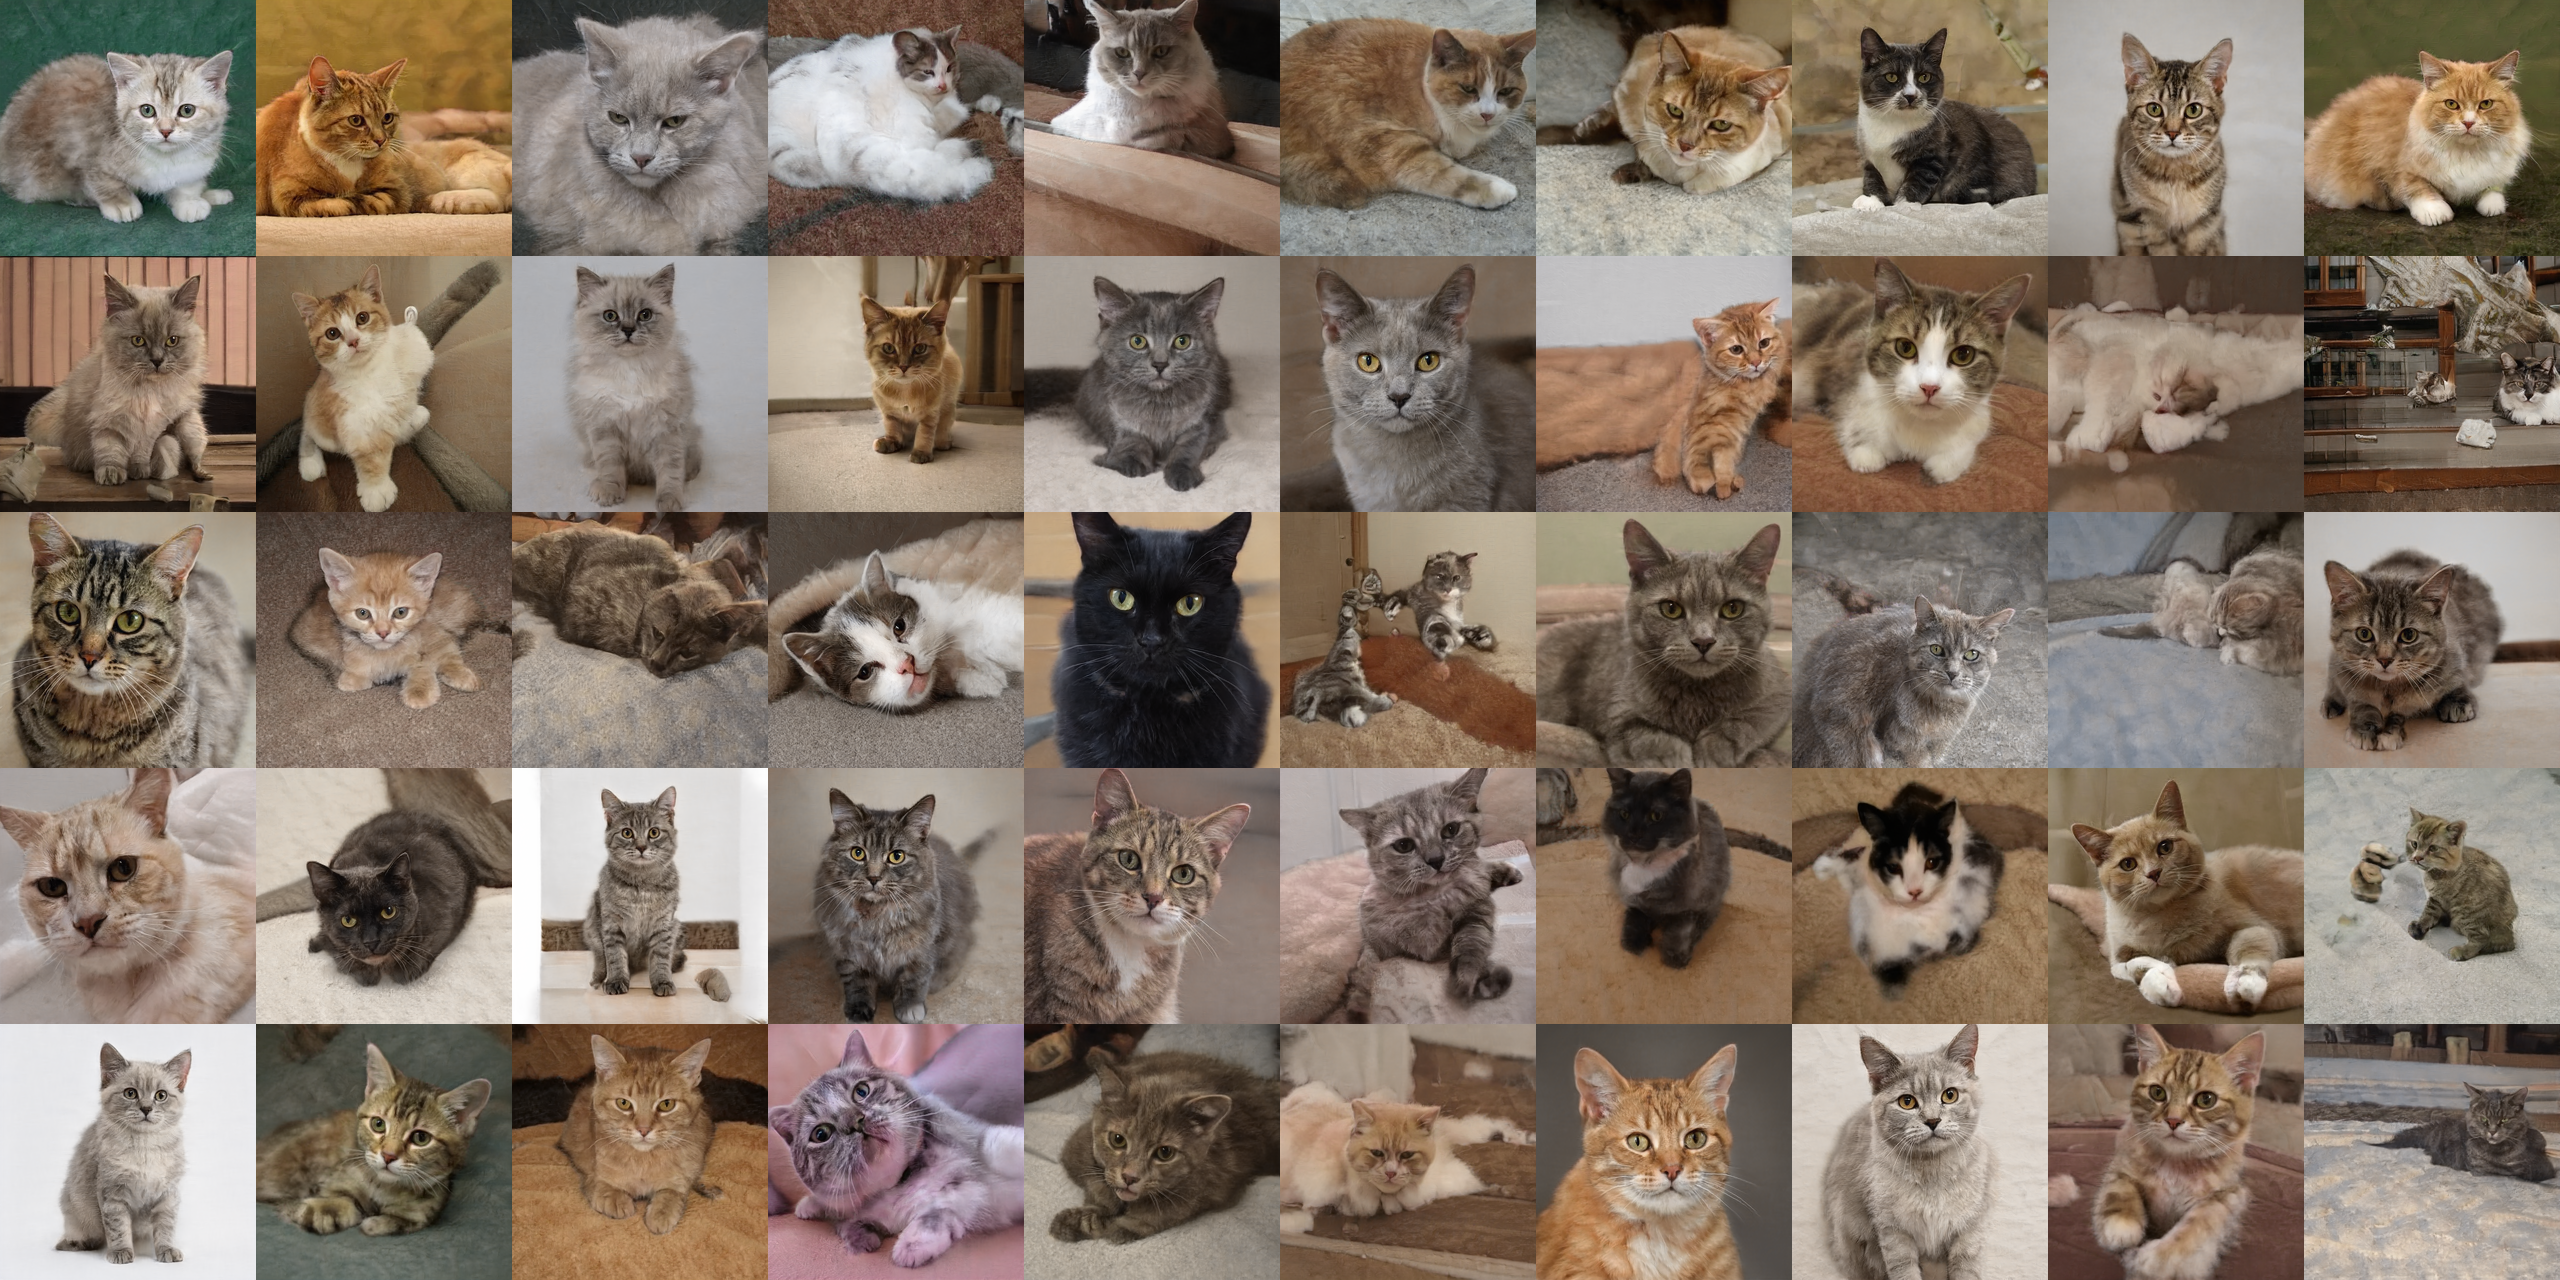

In [6]:
generate_images(
    network_pkl= 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-cat-config-f.pkl',
    seeds= parse_range('201-250'),
    truncation_psi= 0.5,
    noise_mode= 'const',
    translate= parse_vec2('0,0'),
    rotate= 0,
    class_idx= None,
    cols=10,
    scale=1
)